Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/likelihoods/clusterless_kde.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


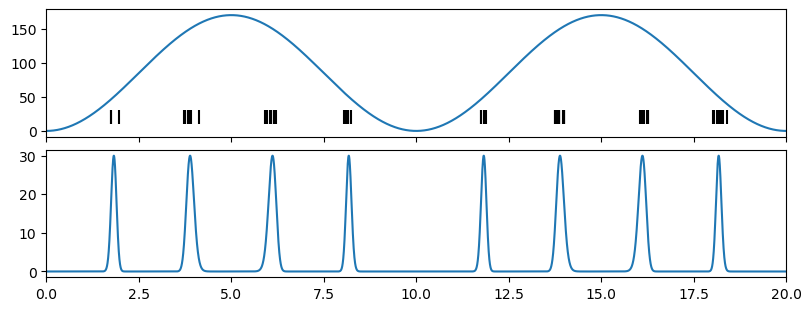

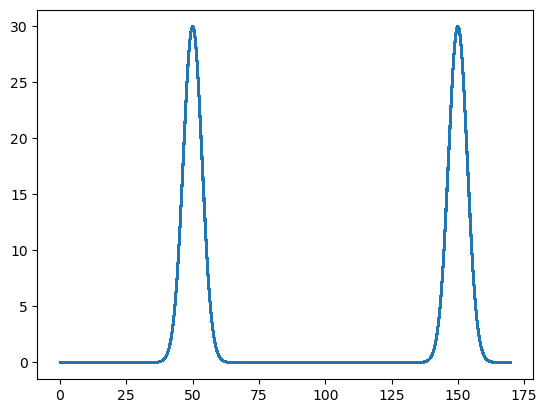

In [1]:
from non_local_detector.simulate.sorted_spikes_simulation import (
    simulate_place_field_firing_rate,
    simulate_position,
    simulate_time,
    simulate_poisson_spikes,
)
import numpy as np
import matplotlib.pyplot as plt


track_height = 170
sampling_frequency = 500
n_samples = sampling_frequency * 2000

time = simulate_time(n_samples, sampling_frequency)
position = simulate_position(time, track_height)[:, np.newaxis]

place_field_means = [50, 150]
firing_rates = [
    simulate_place_field_firing_rate(
        mean, position, max_rate=30, variance=12.5, is_condition=None
    )
    for mean in place_field_means
]
firing_rates = np.stack(firing_rates, axis=1).sum(axis=1)
is_spike = simulate_poisson_spikes(firing_rates, sampling_frequency)


spike_times = time[is_spike.astype(bool)]
position_at_spike_times = position[is_spike.astype(bool)]

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 3), constrained_layout=True)
axes[0].plot(time, position)
axes[0].eventplot(spike_times, linelengths=20, lineoffsets=20, colors="black")
axes[0].set_xlim((0, 20))

axes[1].plot(time, firing_rates)

plt.figure()
plt.plot(position, firing_rates)

In [2]:
position_bins = np.linspace(0, track_height, 100)
is_condition1 = ((position > 25) & (position < 75)).squeeze()

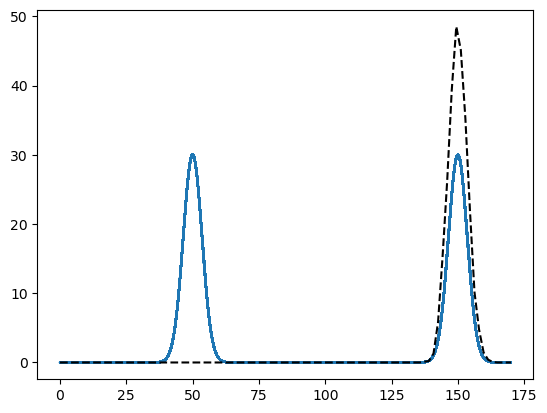

In [3]:
from non_local_detector.likelihoods.common import KDEModel
import scipy.interpolate


EPS = 1e-15

# weights = np.ones_like(position).squeeze()
weights = ~is_condition1
weights_at_spike_times = scipy.interpolate.interpn(
    (time,), weights, spike_times, bounds_error=False, fill_value=None
).squeeze()


silverman_bandwidth = 1.06 * np.sqrt(12.5) * len(position_at_spike_times) ** (-1 / 5)

std = silverman_bandwidth
occupancy = KDEModel(std=std).fit(position, weights=weights).predict(position_bins)
marginal_density = (
    KDEModel(std=std)
    .fit(position_at_spike_times, weights=weights_at_spike_times)
    .predict(position_bins)
)
mean_rate = len(spike_times) / weights.sum()
estimated_rate = np.clip(
    sampling_frequency
    * mean_rate
    * np.where(occupancy > 0.0, marginal_density / occupancy, EPS),
    a_min=EPS,
    a_max=None,
)

plt.plot(position, firing_rates)

plt.plot(
    position_bins,
    estimated_rate,
    color="black",
    linestyle="--",
)

In [4]:
from non_local_detector.likelihoods.sorted_spikes_kde import (
    fit_sorted_spikes_kde_encoding_model,
)
from non_local_detector import Environment

env = Environment().fit_place_grid(position)

out = fit_sorted_spikes_kde_encoding_model(
    time,
    position=position,
    spike_times=[spike_times],
    environment=env,
    weights=weights,
    sampling_frequency=sampling_frequency,
    position_std=std,
)

Encoding models:   0%|          | 0/1 [00:00<?, ?cell/s]

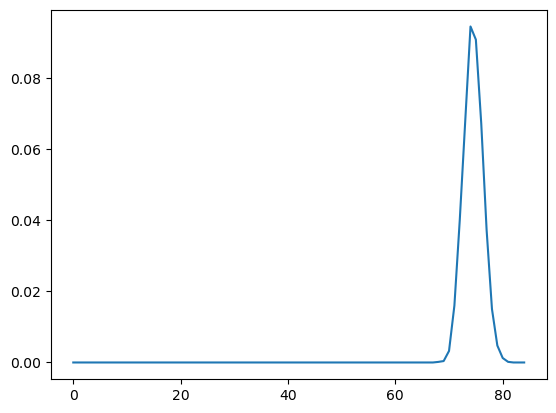

In [5]:
plt.plot(out["place_fields"][0])

In [6]:
out.keys()

dict_keys(['environment', 'marginal_models', 'occupancy_model', 'occupancy', 'mean_rates', 'place_fields', 'no_spike_part_log_likelihood', 'is_track_interior', 'disable_progress_bar'])

In [9]:
from non_local_detector.likelihoods.sorted_spikes_kde import (
    predict_sorted_spikes_kde_log_likelihood,
)

log_likelihood = predict_sorted_spikes_kde_log_likelihood(
    time, time, position, [spike_times], **out
)
local_log_likelihood = predict_sorted_spikes_kde_log_likelihood(
    time, time, position, [spike_times], **out, is_local=True
)

Non-Local Likelihood:   0%|          | 0/1 [00:00<?, ?cell/s]

Local Likelihood:   0%|          | 0/1 [00:00<?, ?cell/s]

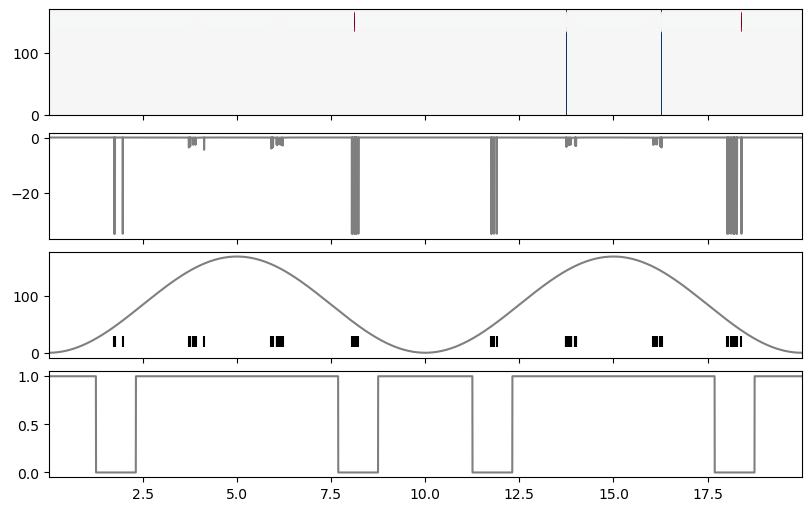

In [25]:
time_slice = slice(5, 10_000)

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(8, 5), constrained_layout=True)
axes[0].pcolormesh(
    time[time_slice],
    env.place_bin_centers_,
    (log_likelihood[time_slice] - local_log_likelihood[time_slice]).T,
    cmap="RdBu_r",
)
axes[1].plot(
    time[time_slice], local_log_likelihood[time_slice], color="black", alpha=0.5
)
axes[2].plot(time[time_slice], position[time_slice], color="black", alpha=0.5)
axes[2].eventplot(
    spike_times[
        (spike_times > time[time_slice.start]) & (spike_times < time[time_slice.stop])
    ],
    linelengths=20,
    lineoffsets=20,
    colors="black",
)
axes[3].plot(time[time_slice], weights[time_slice], color="black", alpha=0.5)

In [86]:
from non_local_detector.simulate.sorted_spikes_simulation import make_simulated_data

(
    speed,
    position,
    spike_times,
    time,
    event_times,
    sampling_frequency,
    is_event,
    place_fields,
) = make_simulated_data()

In [87]:
env = Environment().fit_place_grid(position[:, None])
weights = (~is_event).squeeze().astype(float)
# weights = np.ones_like(position).squeeze()

out1 = fit_sorted_spikes_kde_encoding_model(
    time,
    position=position[:, None],
    spike_times=spike_times,
    environment=env,
    weights=weights,
    sampling_frequency=sampling_frequency,
    position_std=std,
)

Encoding models:   0%|          | 0/25 [00:00<?, ?cell/s]

In [88]:
log_likelihood = predict_sorted_spikes_kde_log_likelihood(
    time, time, position, spike_times, **out1
)

Non-Local Likelihood:   0%|          | 0/25 [00:00<?, ?cell/s]

In [89]:
local_log_likelihood = predict_sorted_spikes_kde_log_likelihood(
    time, time, position, spike_times, **out1, is_local=True
)

Local Likelihood:   0%|          | 0/25 [00:00<?, ?cell/s]

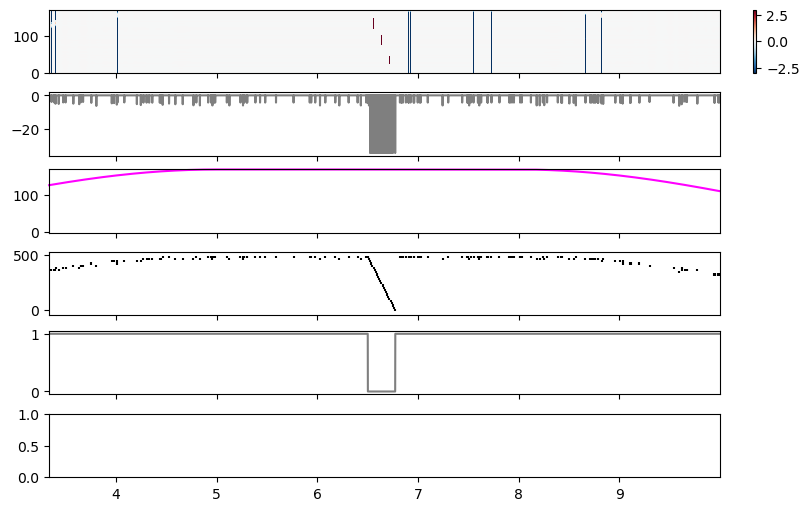

In [90]:
time_slice = slice(5000, 15_000)

fig, axes = plt.subplots(6, 1, sharex=True, figsize=(8, 5), constrained_layout=True)

# max_abs_diff = np.abs(log_likelihood - local_log_likelihood).max() * .5
max_abs_diff = 3
min_diff, max_diff = -max_abs_diff, max_abs_diff
g = axes[0].pcolormesh(
    time[time_slice],
    env.place_bin_centers_,
    (log_likelihood[time_slice] - local_log_likelihood[time_slice]).T,
    cmap="RdBu_r",
    vmin=min_diff,
    vmax=max_diff,
)
plt.colorbar(g, ax=axes[0])
axes[1].plot(
    time[time_slice], local_log_likelihood[time_slice], color="black", alpha=0.5
)
axes[2].plot(time[time_slice], position[time_slice], color="magenta", clip_on=False)
axes[2].set_ylim((position.min() - 1, position.max() + 1))
axes[3].eventplot(
    [
        neuron_spike_times[
            (neuron_spike_times > time[time_slice.start])
            & (neuron_spike_times < time[time_slice.stop])
        ] for neuron_spike_times in spike_times
    ],
    linelengths=20,
    lineoffsets=20,
    colors="black",
)
axes[4].plot(time[time_slice], weights[time_slice], color="black", alpha=0.5)

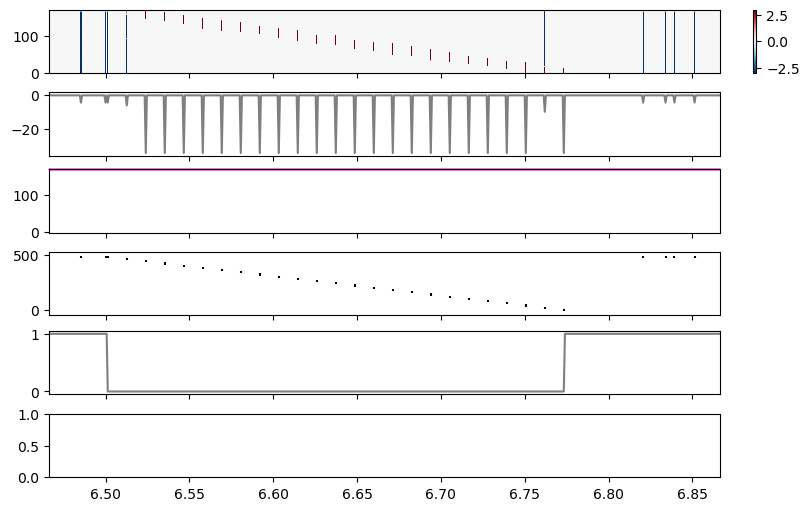

In [91]:
time_slice = slice(9700, 10_300)

fig, axes = plt.subplots(6, 1, sharex=True, figsize=(8, 5), constrained_layout=True)

# max_abs_diff = np.abs(log_likelihood - local_log_likelihood).max() * .5
max_abs_diff = 3
min_diff, max_diff = -max_abs_diff, max_abs_diff
g = axes[0].pcolormesh(
    time[time_slice],
    env.place_bin_centers_,
    (log_likelihood[time_slice] - local_log_likelihood[time_slice]).T,
    cmap="RdBu_r",
    vmin=min_diff,
    vmax=max_diff,
)
plt.colorbar(g, ax=axes[0])
axes[1].plot(
    time[time_slice], local_log_likelihood[time_slice], color="black", alpha=0.5
)
axes[2].plot(time[time_slice], position[time_slice], color="magenta", clip_on=False)
axes[2].set_ylim((position.min() - 1, position.max() + 1))
axes[3].eventplot(
    [
        neuron_spike_times[
            (neuron_spike_times > time[time_slice.start])
            & (neuron_spike_times < time[time_slice.stop])
        ]
        for neuron_spike_times in spike_times
    ],
    linelengths=20,
    lineoffsets=20,
    colors="black",
)
axes[4].plot(time[time_slice], weights[time_slice], color="black", alpha=0.5)

In [92]:
weights = np.ones_like(position).squeeze()

out2 = fit_sorted_spikes_kde_encoding_model(
    time,
    position=position[:, None],
    spike_times=spike_times,
    environment=env,
    weights=weights,
    sampling_frequency=sampling_frequency,
    position_std=std,
)
log_likelihood = predict_sorted_spikes_kde_log_likelihood(
    time, time, position, spike_times, **out2
)
local_log_likelihood = predict_sorted_spikes_kde_log_likelihood(
    time, time, position, spike_times, **out2, is_local=True
)

Encoding models:   0%|          | 0/25 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/25 [00:00<?, ?cell/s]

Local Likelihood:   0%|          | 0/25 [00:00<?, ?cell/s]

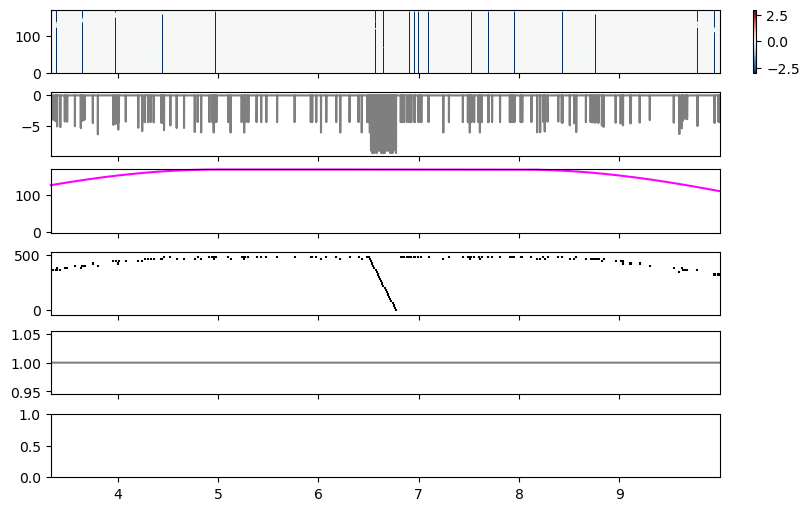

In [93]:
time_slice = slice(5000, 15_000)

fig, axes = plt.subplots(6, 1, sharex=True, figsize=(8, 5), constrained_layout=True)

# max_abs_diff = np.abs(log_likelihood - local_log_likelihood).max() * .5
max_abs_diff = 3
min_diff, max_diff = -max_abs_diff, max_abs_diff
g = axes[0].pcolormesh(
    time[time_slice],
    env.place_bin_centers_,
    (log_likelihood[time_slice] - local_log_likelihood[time_slice]).T,
    cmap="RdBu_r",
    vmin=min_diff,
    vmax=max_diff,
)
plt.colorbar(g, ax=axes[0])
axes[1].plot(
    time[time_slice], local_log_likelihood[time_slice], color="black", alpha=0.5
)
axes[2].plot(time[time_slice], position[time_slice], color="magenta", clip_on=False)
axes[2].set_ylim((position.min() - 1, position.max() + 1))
axes[3].eventplot(
    [
        neuron_spike_times[
            (neuron_spike_times > time[time_slice.start])
            & (neuron_spike_times < time[time_slice.stop])
        ]
        for neuron_spike_times in spike_times
    ],
    linelengths=20,
    lineoffsets=20,
    colors="black",
)
axes[4].plot(time[time_slice], weights[time_slice], color="black", alpha=0.5)

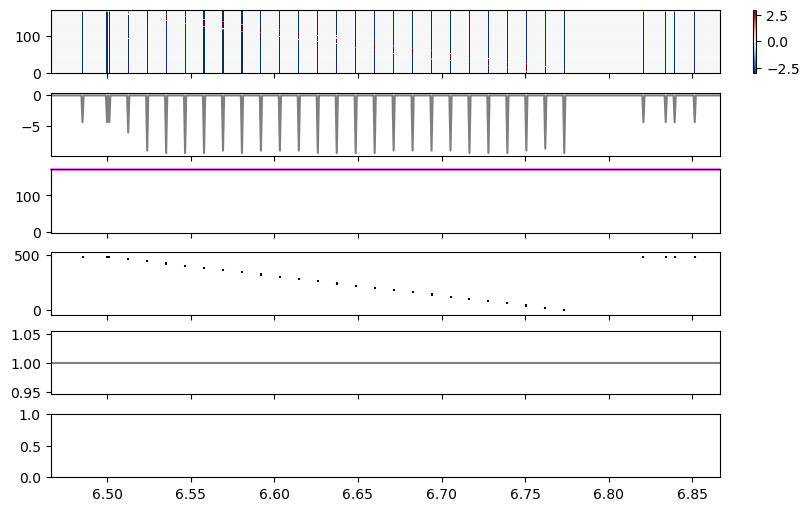

In [94]:
time_slice = slice(9700, 10_300)

fig, axes = plt.subplots(6, 1, sharex=True, figsize=(8, 5), constrained_layout=True)

# max_abs_diff = np.abs(log_likelihood - local_log_likelihood).max() * .5
max_abs_diff = 3
min_diff, max_diff = -max_abs_diff, max_abs_diff
g = axes[0].pcolormesh(
    time[time_slice],
    env.place_bin_centers_,
    (log_likelihood[time_slice] - local_log_likelihood[time_slice]).T,
    cmap="RdBu_r",
    vmin=min_diff,
    vmax=max_diff,
)
plt.colorbar(g, ax=axes[0])
axes[1].plot(
    time[time_slice], local_log_likelihood[time_slice], color="black", alpha=0.5
)
axes[2].plot(time[time_slice], position[time_slice], color="magenta", clip_on=False)
axes[2].set_ylim((position.min() - 1, position.max() + 1))
axes[3].eventplot(
    [
        neuron_spike_times[
            (neuron_spike_times > time[time_slice.start])
            & (neuron_spike_times < time[time_slice.stop])
        ]
        for neuron_spike_times in spike_times
    ],
    linelengths=20,
    lineoffsets=20,
    colors="black",
)
axes[4].plot(time[time_slice], weights[time_slice], color="black", alpha=0.5)

In [96]:
out1["place_fields"].shape, env.place_bin_centers_.shape

((25, 86), (86, 1))

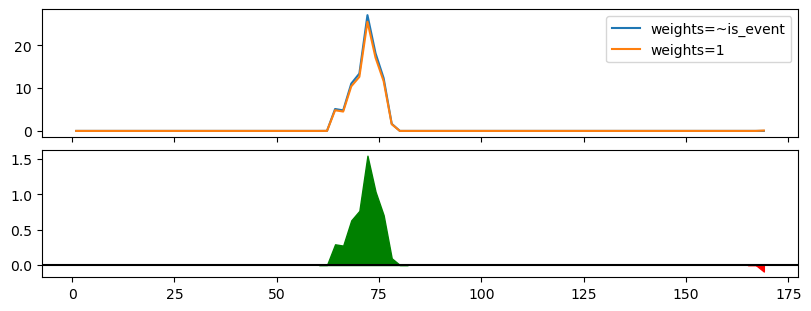

In [114]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 3), constrained_layout=True)
axes[0].plot(env.place_bin_centers_, out1["place_fields"][10] * sampling_frequency, label="weights=~is_event")
axes[0].plot(
    env.place_bin_centers_,
    out2["place_fields"][10] * sampling_frequency,
    label="weights=1",
)
axes[0].legend()

axes[1].fill_between(
    env.place_bin_centers_.squeeze(),
    0.0,
    (out1["place_fields"][10] - out2["place_fields"][10]).squeeze()
    * sampling_frequency,
    color="green",
    where=(out1["place_fields"][10] - out2["place_fields"][10]).squeeze() > 0,
)
axes[1].fill_between(
    env.place_bin_centers_.squeeze(),
    0.0,
    (out1["place_fields"][10] - out2["place_fields"][10]).squeeze() * sampling_frequency,
    color="red",
    where=(out1["place_fields"][10] - out2["place_fields"][10]).squeeze() < 0,
)
axes[1].axhline(0, color="black")